# Audio codec training (mono, 1500 bits/second)

In [1]:
import os; os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "garbage_collection_threshold:0.5"
import io, time, torch, random, torchaudio, datasets, PIL.Image, pillow_jpls, fastprogress, IPython.display
import numpy as np, matplotlib.pyplot as plt
from itertools import combinations
from einops.layers.torch import Rearrange
from types import SimpleNamespace
from typing import OrderedDict
from torchvision.transforms.v2.functional import pil_to_tensor, to_pil_image
from torchvision.transforms import Compose, Resize, RandomCrop, CenterCrop, ColorJitter
from livecodec.codec import AutoCodecND, latent_to_pil, pil_to_latent
from timm.optim import Adan

In [2]:
device="cuda:3"
dataset = datasets.load_dataset("danjacobellis/musdb_segments")

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
config.F = 1024
config.latent_dim = 16
config.input_channels = 1
config.encoder_depth = 4
config.encoder_kernel_size = 1
config.decoder_depth = 8
config.lightweight_encode = True
config.lightweight_decode = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.lr_pow = 6
config.batch_size = 4
config.max_lr = 1e-4
config.min_lr = 1e-7
config.num_workers = 8
config.epochs = 1000
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.L = 450560
config.save_checkpoint_name = 'f1024c8.pth'

In [4]:
model = AutoCodecND(
    dim=1,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)

optimizer = Adan(model.parameters(), lr=1.0)
def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)
print(sum(p.numel() for p in model.parameters())/1e6)

135.449872


In [5]:
mixing_weights = []

# Original mixture
mixing_weights.append(torch.ones(4))

# Amplify two channels, attenuate two
for indices in combinations(range(4), 2):
    weights = torch.full((4,), 0.5)
    weights[list(indices)] = 1.5
    mixing_weights.append(weights)

# Combinations of 3 channels (set to 1.0), one channel set to 0.0
for indices in combinations(range(4), 3):
    weights = torch.zeros(4)
    weights[list(indices)] = 1.0
    mixing_weights.append(weights)

# Combinations of 2 channels (set to 1.0), others set to 0.0
for indices in combinations(range(4), 2):
    weights = torch.zeros(4)
    weights[list(indices)] = 1.0
    mixing_weights.append(weights)

# Combinations of 1 channel
for index in range(4):
    weights = torch.zeros(4)
    weights[index] = 1.0
    mixing_weights.append(weights)

def train_collate_fn(batch):
    L = config.L
    C = config.input_channels
    crop = RandomCrop((4, L))
    B = len(batch)
    x = torch.zeros((B, C, L), dtype=torch.float)
    for i_sample, sample in enumerate(batch):
        xi = torch.zeros((C,4,2**21), dtype=torch.float)
        for i_instr, instr in enumerate(['vocal', 'bass', 'drums', 'other']):
            audio, fs = torchaudio.load(sample[f'audio_{instr}']['bytes'])
            audio = audio.mean(dim=0,keepdim=True)
            xi[:,i_instr,:] = audio
        xi = crop(xi)
        w = random.choice(mixing_weights).view(1, -1, 1)
        xi = (w*xi).sum(dim=1)
        xi = xi - xi.mean()
        max_abs = xi.abs().max()
        xi = xi / (max_abs + 1e-8)
        x[i_sample,:,:] = xi
    return x

def enc_dec(sample):
    x, fs = torchaudio.load(sample['audio_mix']['bytes'])
    x = x.mean(dim=0,keepdim=True)
    x = CenterCrop((1,config.L))(x)

    with torch.inference_mode():
        x = x.unsqueeze(0).to(device)
        t0 = time.time()
        z = model.quantize.compand(model.encode(x)).round()
        compressed = latent_to_pil(z.unsqueeze(0).cpu(),n_bits=8,C=1)[0]
        enc_time = time.time() - t0
        buff = io.BytesIO()
        compressed.save(buff,format='JPEG-LS')
        size_bytes = len(buff.getbuffer())
        t0 = time.time()
        z = pil_to_latent([PIL.Image.open(buff)],N=1, n_bits=8, C=1)[0]
        xhat = model.decode(z.to(device)).clamp(-1,1)
        dec_time = time.time() - t0
        x_01 = x/2 + 0.5
        xhat_01 = xhat/2 + 0.5
        psnr = -10*torch.nn.functional.mse_loss(x_01, xhat_01).log10().item()
    del sample
    return{
        'psnr': psnr,
        'cr': x.numel()/size_bytes,
        'enc': (x.numel()/1e6)/enc_time,
        'dec': (x.numel()/1e6)/dec_time
    }

In [6]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = fastprogress.master_bar(range(config.epochs))
log_mse_losses = []
rate_losses = []
valid_metrics = []
global_step = 0
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=train_collate_fn
        )
    pb = fastprogress.progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)
        if i_epoch/config.epochs <= config.freeze_encoder_after :
            # Soft quantization with additive noise
            x_hat, rate = model(x)
        else:
            # Hard quantization
            with torch.no_grad():
                z = model.quantize.compand(model.encode(x))
                z_quant = z.round()
            rate = z.std().log2()              
            x_hat = model.decode(z_quant)

        # Loss and optimizer
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        log_mse_losses.append(mse_loss.item())
        rate_losses.append(rate.item())
        total_loss = mse_loss + config.λ * rate
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*log_mse_losses[-1]+6.02:.3g}, R: {rate:.2g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1

    model.eval()
    valid = []
    for sample in fastprogress.progress_bar(dataset['validation'],parent=mb):
        valid.append(enc_dec(sample))
    valid = datasets.Dataset.from_list(valid)
    valid_metrics.append({key: torch.tensor(valid[key]).mean().item() for key in valid.features.keys()})
    mb.main_bar.comment = ";  ".join([f'{key}: {valid_metrics[-1][key]:0.4g}' for key in valid_metrics[-1]])
    
    torch.save({
        'i_epoch': i_epoch,
        'log_mse_losses': log_mse_losses,
        'learning_rates': learning_rates,
        'valid_metrics': {k: [d[k] for d in valid_metrics] for k in valid_metrics[0].keys()},
        'config': config,
        'state_dict': model.state_dict()
    }, config.save_checkpoint_name)

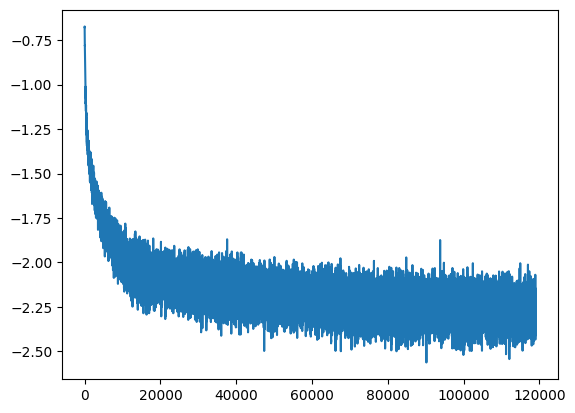

In [7]:
display(IPython.display.HTML(mb.main_bar.progress))
display(IPython.display.HTML(pb.progress))
N = 11; plt.plot(np.convolve(log_mse_losses, N*[1/N], mode='valid'))
# plt.ylim([-4,-2])

In [8]:
torch.save({
    'config': config,
    'valid_metrics':valid_metrics,
    'state_dict': model.state_dict()
},  '../../../hf/liveaction/musdb_f1024c16')